In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
from astropy.cosmology import FlatLambdaCDM

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [45]:
plt.show();
plt.rcParams.update({'font.size':16,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})

# Definitions for this notebook:

In [3]:
z_directory = {"33":"z=2","40":"z=1.5","50":"z=1"}

In [4]:
orbit_dict = {}
for snap in [33,40,50]:
    f = h5py.File(f"{paths.path_data}orbitdata_{snap}.hdf5",'r')
    orbit_dict[str(snap)] = {}
    for key, val in f.items():
        orbit_dict[str(snap)][key] = np.array(val)
    f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
snap_dict = {}
for key, val in f.items():
    snap_dict[key] = np.array(val)
f.close()

# Comparison plot for merger timescales at z=1,1.5,2

### Plot of merged and unmerged at each redshift

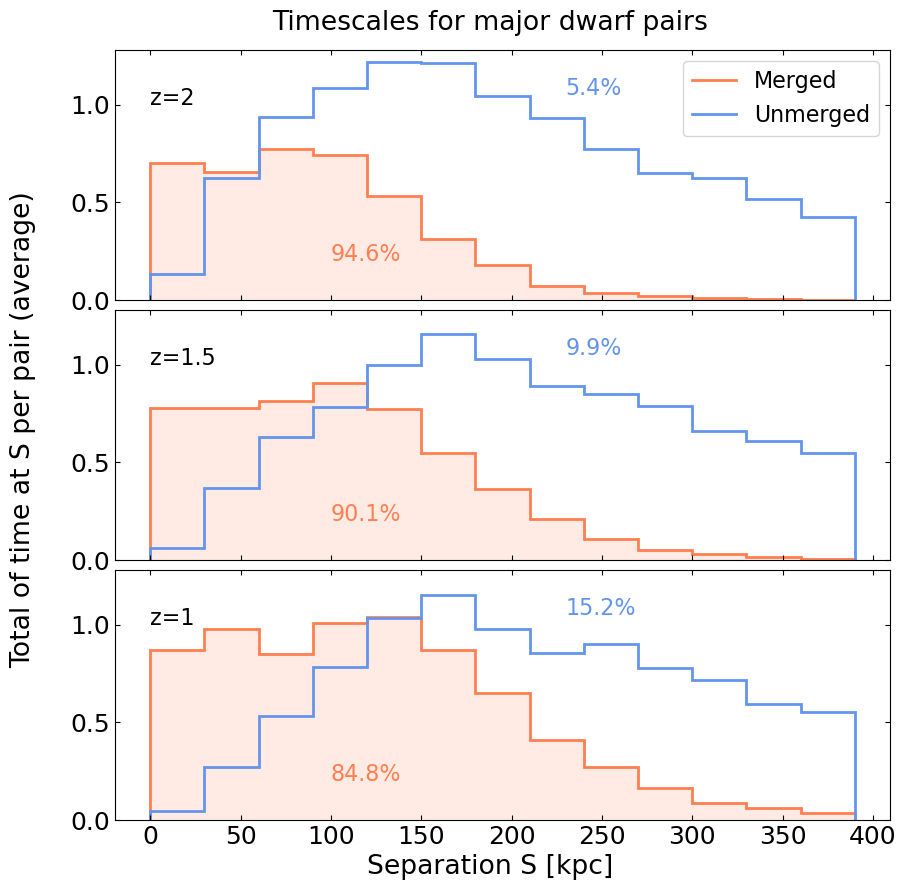

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(10,10), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.10,
                                    "hspace":0.04})
z={"33":"z=2","40":"z=1.5","50":"z=1"}


for ii, snap in enumerate([33, 40, 50]):
    orb = orbit_dict[str(snap)]
    sep_matrix = orb["Separations"]
    elapsed_time = np.diff(snap_dict["Lookback Time"][1:][::-1])
    
    # array of the elapsed time with a nan value in the place of z=0
    elapsed_noz0 = np.concatenate((np.array([np.nan]),elapsed_time))
    elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

    nan_elapsed = np.isnan(elapsed_matrix)
    nan_sep = np.isnan(sep_matrix)
    zero_sep = sep_matrix == 0
    matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep
    
    merger_array = np.array(orb["MergerFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(99,1)).transpose()

    elapsed_masked = elapsed_matrix[matrix_mask]
    sep_masked = sep_matrix[matrix_mask]

    ## calculate histograms
    xx_merge = sep_matrix[matrix_mask&merge_mask]
    xx_unmerge = sep_matrix[matrix_mask&~merge_mask]

    yy_merge = elapsed_matrix[matrix_mask&merge_mask]
    yy_unmerge = elapsed_matrix[matrix_mask&~merge_mask]

    num_mergers = np.sum(merge_mask,axis=0)[0]
    num_unmerged = np.sum(~merge_mask,axis=0)[0]
    num_pairs = num_mergers + num_unmerged
    bins = np.arange(0,400,30)

    merged_vals, merged_edges = np.histogram(xx_merge,bins=bins,weights=yy_merge/num_mergers)
    unmerged_vals, unmerged_edges = np.histogram(xx_unmerge,bins=bins,weights=yy_unmerge/num_unmerged)

    ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,fill=True,alpha=0.15)
    ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,label="Merged")
    ax[ii].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=2,label="Unmerged")
    
    ax[ii].text(0,1,f"{z[str(snap)]}")
    ax[ii].text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
    ax[ii].text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")
    
    
ax[0].legend()
fig.suptitle("Timescales for major dwarf pairs",y=0.92)
fig.supxlabel("Separation S [kpc]",y=0.05)
fig.supylabel("Total of time at S per pair (average)")
plt.show()


#### just z=1.5

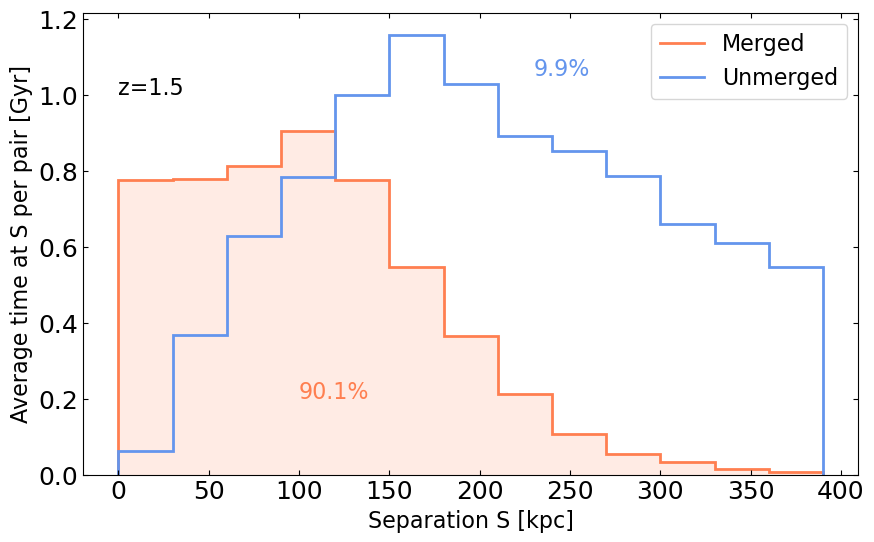

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,6), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1],
                                    'wspace': 0.10,
                                    "hspace":0.04})
z={"33":"z=2","40":"z=1.5","50":"z=1"}



snap = 40
orb = orbit_dict[str(snap)]
sep_matrix = orb["Separations"]
elapsed_time = np.diff(snap_dict["Lookback Time"][1:][::-1])

# array of the elapsed time with a nan value in the place of z=0
elapsed_noz0 = np.concatenate((np.array([np.nan]),elapsed_time))
elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

nan_elapsed = np.isnan(elapsed_matrix)
nan_sep = np.isnan(sep_matrix)
zero_sep = sep_matrix == 0
matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep

merger_array = np.array(orb["MergerFlag"],dtype='bool')
merge_mask = np.tile(merger_array,(99,1)).transpose()

elapsed_masked = elapsed_matrix[matrix_mask]
sep_masked = sep_matrix[matrix_mask]

## calculate histograms
xx_merge = sep_matrix[matrix_mask&merge_mask]
xx_unmerge = sep_matrix[matrix_mask&~merge_mask]

yy_merge = elapsed_matrix[matrix_mask&merge_mask]
yy_unmerge = elapsed_matrix[matrix_mask&~merge_mask]

num_mergers = np.sum(merge_mask,axis=0)[0]
num_unmerged = np.sum(~merge_mask,axis=0)[0]
num_pairs = num_mergers + num_unmerged
bins = np.arange(0,400,30)

merged_vals, merged_edges = np.histogram(xx_merge,bins=bins,weights=yy_merge/num_mergers)
unmerged_vals, unmerged_edges = np.histogram(xx_unmerge,bins=bins,weights=yy_unmerge/num_unmerged)

ax.stairs(merged_vals,merged_edges,color="coral",lw=2,fill=True,alpha=0.15)
ax.stairs(merged_vals,merged_edges,color="coral",lw=2,label="Merged")
ax.stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=2,label="Unmerged")

ax.text(0,1,f"{z[str(snap)]}")
ax.text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
ax.text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")


ax.legend()
# fig.suptitle("Timescales for major dwarf pairs",y=0.92)
ax.set_xlabel("Separation S [kpc]")
ax.set_ylabel("Average time at S per pair [Gyr]")
plt.show()


### Plot of merged at each redshift and unmerged at each redshift

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.10,
                                    "hspace":0.04})
z={"33":"z=2","40":"z=1.5","50":"z=1"}


for ii, snap in enumerate([33, 40, 50]):
    orb = orbit_dict[str(snap)]
    sep_matrix = orb["Separations"]
    elapsed_time = np.diff(snap_dict["Lookback Time"][1:][::-1])
    
    # array of the elapsed time with a nan value in the place of z=0
    elapsed_noz0 = np.concatenate((np.array([np.nan]),elapsed_time))
    elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

    nan_elapsed = np.isnan(elapsed_matrix)
    nan_sep = np.isnan(sep_matrix)
    zero_sep = sep_matrix == 0
    matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep
    
    merger_array = np.array(orb["MergerFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(99,1)).transpose()

    elapsed_masked = elapsed_matrix[matrix_mask]
    sep_masked = sep_matrix[matrix_mask]

    ## calculate histograms
    xx_merge = sep_matrix[matrix_mask&merge_mask]
    xx_unmerge = sep_matrix[matrix_mask&~merge_mask]

    yy_merge = elapsed_matrix[matrix_mask&merge_mask]
    yy_unmerge = elapsed_matrix[matrix_mask&~merge_mask]

    num_mergers = np.sum(merge_mask,axis=0)[0]
    num_unmerged = np.sum(~merge_mask,axis=0)[0]
    num_pairs = num_mergers + num_unmerged
    bins = np.arange(0,400,25)

    merged_vals, merged_edges = np.histogram(xx_merge,bins=bins,weights=yy_merge/num_mergers)
    unmerged_vals, unmerged_edges = np.histogram(xx_unmerge,bins=bins,weights=yy_unmerge/num_unmerged)

    ax[0].stairs(merged_vals,merged_edges,color="coral",lw=ii,fill=True,alpha=0.15)
    ax[0].stairs(merged_vals,merged_edges,color="coral",lw=ii,label=f"{z[str(snap)]}")
    ax[1].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=ii,fill=True,alpha=0.15)
    ax[1].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=ii,label=f"{z[str(snap)]}")
    
#     ax[ii].text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
#     ax[ii].text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")
    
    
ax[0].legend(title="Merged")
ax[1].legend(title="Unmerged")
fig.suptitle("Timescales for major dwarf pairs",y=0.92)
fig.supxlabel("Separation S [kpc]",y=0.05)
fig.supylabel("Total of time at S per pair (average)")
plt.show()


# Comoving vs Physical separations

note: the redshifts in the snap_dict are saved from 0 to 99, counting upwards. However, the orbits are saved with the first element corresponding to z = 0 (snapshot 99) and down to snapshot 1 (not including snapshot 0, so need to reverse the scale/redshift/snapshot numbers from snap_dict, AND remove the snap=0 element. 

In [ ]:
# gives scale from snapshot 99 -> 1 (in same order as orbit data)
ordered_scale = snap_dict['Scale'][::-1][:-1]


goal: plot the histogram of physical separations, and the histogram of comoving separations!
first, only focus on the merged group

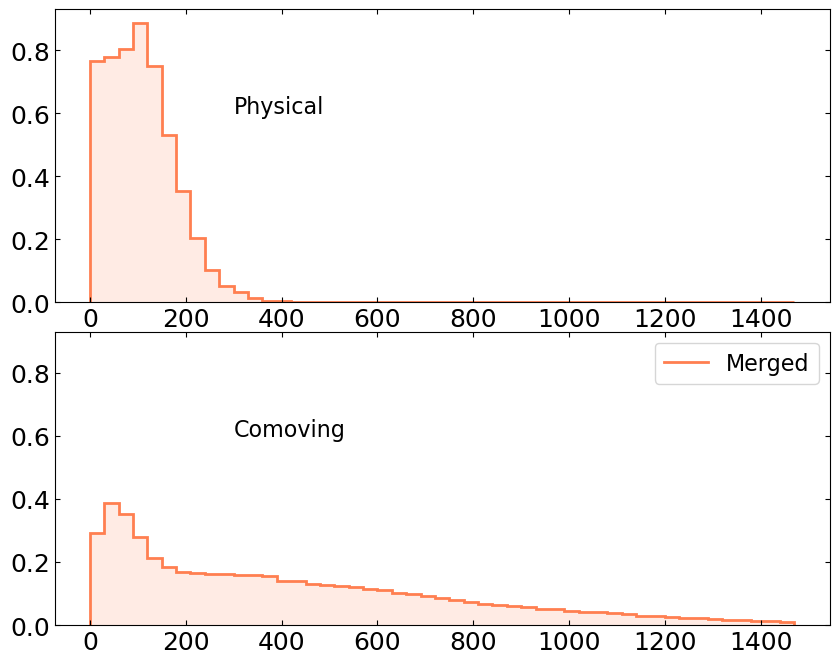

In [7]:
'''
# trying slight modification of the elapsed_time array construction compared to previous plots
# this approximates that a pair stayed at the same separation for the amount of 
# time elapsed since the snapshot before
---
might need to do something else if we are only considering seps > 10kpc? 
'''

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharey=True, sharex=False, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.10,
                                    "hspace":0.1})
    # get physical separations from snapshot 40
snap = 40
orb = orbit_dict[str(snap)]
sep_matrix_kpc = orb["Separations"]
    
    # get comoving separations
scales = snap_dict['Scale'][::-1][:-1] # gives scale in same order as orbit data
scale_matrix = np.tile(scales,(len(sep_matrix_kpc),1))
sep_matrix_ckpc = sep_matrix_kpc/scale_matrix

    # get elapsed time (positive)
elapsed_time = np.diff(snap_dict["Lookback Time"][::-1]) 
elapsed_matrix = np.tile(elapsed_time,(len(sep_matrix_kpc),1))

    # create mask to filter out nan and zero values from the separation matrix
nan_sep = np.isnan(sep_matrix_kpc)
zero_sep = sep_matrix_kpc == 0
matrix_mask = ~nan_sep&~zero_sep

    # create mask to only select mergers
merger_array = np.array(orb["MergerFlag"],dtype='bool')
merge_mask = np.tile(merger_array,(99,1)).transpose()

    # calculate number of mergers and elapsed time - used for weights 
elapsed = elapsed_matrix[matrix_mask&merge_mask]
num_mergers = np.sum(merge_mask,axis=0)[0]

    # define bins for histograms
bins_kpc = np.arange(0,1500,30)
bins_ckpc = np.arange(0,1500,30)


###                      ###
# physical separation plot #
###                      ###
xx_kpc = sep_matrix_kpc[matrix_mask&merge_mask]
vals_kpc, edges_kpc = np.histogram(xx_kpc,bins=bins_kpc,weights=elapsed/num_mergers)

ax[0].stairs(vals_kpc,edges_kpc,color="coral",lw=2,fill=True,alpha=0.15)
ax[0].stairs(vals_kpc,edges_kpc,color="coral",lw=2,label="Merged")
ax[0].text(300,0.6,f"Physical")

###                      ###
# comoving separation plot #
###                      ###
xx_ckpc = sep_matrix_ckpc[matrix_mask&merge_mask]
vals_ckpc, edges_ckpc = np.histogram(xx_ckpc,bins=bins_ckpc,weights=elapsed/num_mergers)

ax[1].stairs(vals_ckpc,edges_ckpc,color="coral",lw=2,fill=True,alpha=0.15)
ax[1].stairs(vals_ckpc,edges_ckpc,color="coral",lw=2,label="Merged")
ax[1].text(300,0.6,f"Comoving")


# ax.text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
# ax.text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")


plt.legend()
# # fig.suptitle("Timescales for major dwarf pairs",y=0.92)
# ax.set_xlabel("Separation S [kpc]")
# ax.set_ylabel("Average time at S per pair [Gyr]")
plt.show()


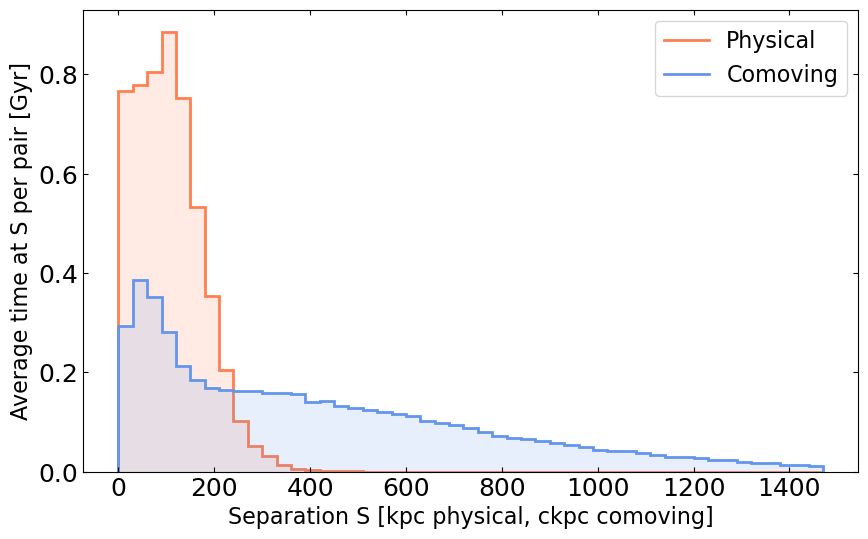

In [28]:
'''
# trying slight modification of the elapsed_time array construction compared to previous plots
# this approximates that a pair stayed at the same separation for the amount of 
# time elapsed since the snapshot before
---
might need to do something else if we are only considering seps > 10kpc? 
'''

fig, ax = plt.subplots(1, 1, figsize=(10,6), sharey=True, sharex=False, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1],
                                    'wspace': 0.10,
                                    "hspace":0.1})
    # get physical separations from snapshot 40
snap = 40
orb = orbit_dict[str(snap)]
sep_matrix_kpc = orb["Separations"]
    
    # get comoving separations
scales = snap_dict['Scale'][::-1][:-1] # gives scale in same order as orbit data
scale_matrix = np.tile(scales,(len(sep_matrix_kpc),1))
sep_matrix_ckpc = sep_matrix_kpc/scale_matrix

    # get elapsed time (positive)
elapsed_time = np.diff(snap_dict["Lookback Time"][::-1]) 
elapsed_matrix = np.tile(elapsed_time,(len(sep_matrix_kpc),1))

    # create mask to filter out nan and zero values from the separation matrix
nan_sep = np.isnan(sep_matrix_kpc)
zero_sep = sep_matrix_kpc == 0
matrix_mask = ~nan_sep&~zero_sep

    # create mask to only select mergers
merger_array = np.array(orb["MergerFlag"],dtype='bool')
merge_mask = np.tile(merger_array,(99,1)).transpose()

    # calculate number of mergers and elapsed time - used for weights 
elapsed = elapsed_matrix[matrix_mask&merge_mask]
num_mergers = np.sum(merge_mask,axis=0)[0]

    # define bins for histograms
bins_kpc = np.arange(0,1500,30)
bins_ckpc = np.arange(0,1500,30)


###                      ###
# physical separation plot #
###                      ###
xx_kpc = sep_matrix_kpc[matrix_mask&merge_mask]
vals_kpc, edges_kpc = np.histogram(xx_kpc,bins=bins_kpc,weights=elapsed/num_mergers)

ax.stairs(vals_kpc,edges_kpc,color="coral",lw=2,fill=True,alpha=0.15)
ax.stairs(vals_kpc,edges_kpc,color="coral",lw=2,label="Physical")
# ax.text(300,0.6,f"Physical")

###                      ###
# comoving separation plot #
###                      ###
xx_ckpc = sep_matrix_ckpc[matrix_mask&merge_mask]
vals_ckpc, edges_ckpc = np.histogram(xx_ckpc,bins=bins_ckpc,weights=elapsed/num_mergers)

ax.stairs(vals_ckpc,edges_ckpc,color="cornflowerblue",lw=2,fill=True,alpha=0.15)
ax.stairs(vals_ckpc,edges_ckpc,color="cornflowerblue",lw=2,label="Comoving")
# ax[1].text(300,0.6,f"Comoving")


# ax.text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
# ax.text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")


plt.legend()
# # fig.suptitle("Timescales for major dwarf pairs",y=0.92)
ax.set_xlabel("Separation S [kpc physical, ckpc comoving]")
ax.set_ylabel("Average time at S per pair [Gyr]")
plt.show()


In [30]:
elapsed

array([0.1390652 , 0.18227452, 0.13435103, ..., 0.04223414, 0.05697626,
       0.04752168])

# Changing Orbit start times 

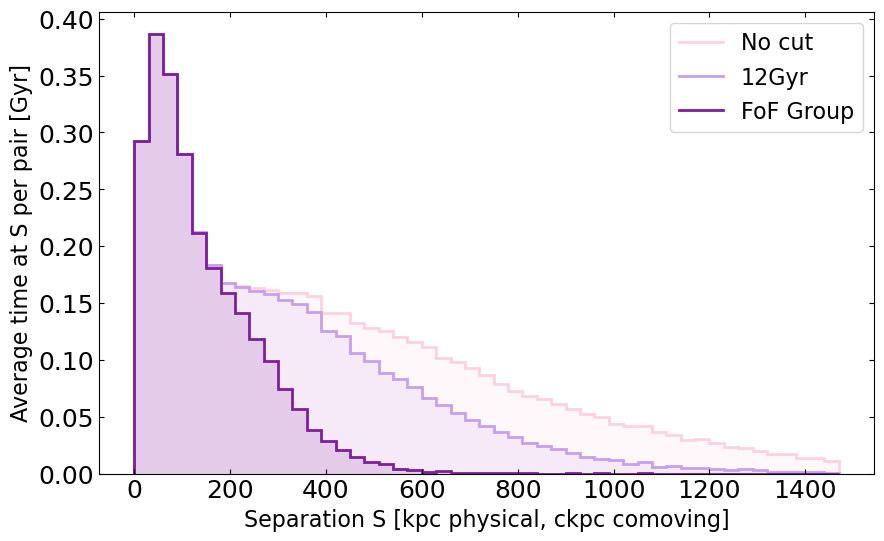

In [94]:
'''
# trying slight modification of the elapsed_time array construction compared to previous plots
# this approximates that a pair stayed at the same separation for the amount of 
# time elapsed since the snapshot before
---
might need to do something else if we are only considering seps > 10kpc? 
'''
fig, ax = plt.subplots(1, 1, figsize=(10,6), sharey=True, sharex=False, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1],
                                    'wspace': 0.10,
                                    "hspace":0.1})
    # get physical separations from snapshot 40
snap = 40
orb = orbit_dict[str(snap)]
sep_matrix_kpc = orb["Separations"]

colors = ["xkcd:light pink","xkcd:lavender","xkcd:purple"]
j = 0    

for i in ["No cut","12Gyr","FoF Group"]:


        # get comoving separations
    scales = snap_dict['Scale'][::-1][:-1] # gives scale in same order as orbit data
    scale_matrix = np.tile(scales,(len(sep_matrix_kpc),1))
    sep_matrix_ckpc = sep_matrix_kpc/scale_matrix

        # get elapsed time (positive)
    elapsed_time = np.diff(snap_dict["Lookback Time"][::-1]) 
    elapsed_matrix = np.tile(elapsed_time,(len(sep_matrix_kpc),1))

        # create mask to filter out nan and zero values from the separation matrix
    nan_sep = np.isnan(sep_matrix_kpc)
    zero_sep = sep_matrix_kpc == 0
    matrix_mask = ~nan_sep&~zero_sep

        # create mask to only select mergers
    merger_array = np.array(orb["MergerFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(99,1)).transpose()

        # define bins for histograms
    bins_kpc = np.arange(0,1500,30)
    bins_ckpc = np.arange(0,1500,30)
    
        # orbit start at LBT of 12Gyr
    start_12gyrmask = (snap_dict["Lookback Time"][::-1][:-1] < 12)    
    start_12gyr = np.tile(start_12gyrmask,(len(sep_matrix_kpc),1))
    
        # orbit start when in same FoF group
    start_FoF = orb['GroupFlag'] == True


    if i == "12Gyr":
        xx_ckpc = sep_matrix_ckpc[matrix_mask&merge_mask&start_12gyr]
            # calculate number of mergers and elapsed time - used for weights 
        elapsed = elapsed_matrix[matrix_mask&merge_mask&start_12gyr]
        num_mergers = np.sum(merge_mask,axis=0)[0]
        
    elif i =="FoF Group":
        xx_ckpc = sep_matrix_ckpc[matrix_mask&merge_mask&start_FoF]
            # calculate number of mergers and elapsed time - used for weights 
        elapsed = elapsed_matrix[matrix_mask&merge_mask&start_FoF]
        num_mergers = np.sum(merge_mask,axis=0)[0]
        
    else:
        xx_ckpc = sep_matrix_ckpc[matrix_mask&merge_mask]
            # calculate number of mergers and elapsed time - used for weights 
        elapsed = elapsed_matrix[matrix_mask&merge_mask]
        num_mergers = np.sum(merge_mask,axis=0)[0]

    vals_ckpc, edges_ckpc = np.histogram(xx_ckpc,bins=bins_ckpc,weights=elapsed/num_mergers)

    ax.stairs(vals_ckpc,edges_ckpc,color=colors[j],lw=2,fill=True,alpha=0.15)
    ax.stairs(vals_ckpc,edges_ckpc,color=colors[j],lw=2,label=i)
        

# ax[1].text(300,0.6,f"Comoving")


# ax.text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
# ax.text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")
    j += 1

plt.legend()
# # fig.suptitle("Timescales for major dwarf pairs",y=0.92)
ax.set_xlabel("Separation S [kpc physical, ckpc comoving]")
ax.set_ylabel("Average time at S per pair [Gyr]")
plt.show()





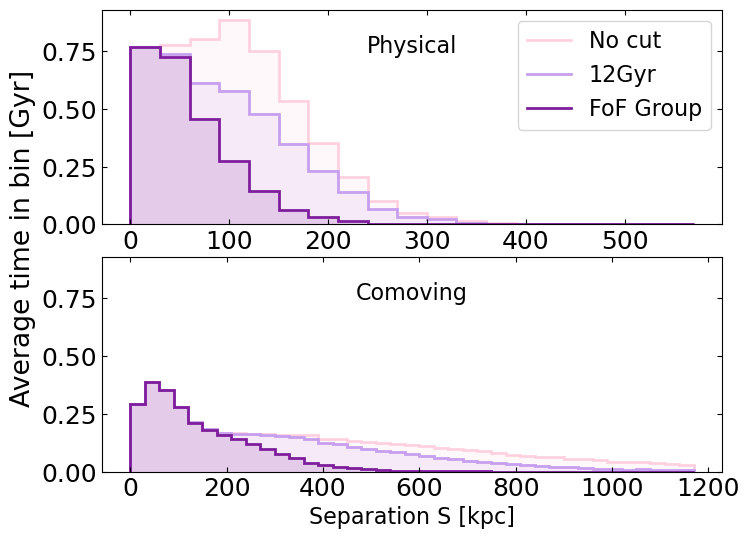

In [93]:
'''
# trying slight modification of the elapsed_time array construction compared to previous plots
# this approximates that a pair stayed at the same separation for the amount of 
# time elapsed since the snapshot before
---
might need to do something else if we are only considering seps > 10kpc? 
'''

fig, ax = plt.subplots(2, 1, figsize=(8,6), sharey=True, sharex=False, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.10,
                                    "hspace":0.15})

    # get physical separations from snapshot 40
snap = 40
orb = orbit_dict[str(snap)]
sep_matrix_kpc = orb["Separations"]

colors = ["xkcd:light pink","xkcd:lavender","xkcd:purple"]
j = 0    

for i in ["No cut","12Gyr","FoF Group"]:


        # get comoving separations
    scales = snap_dict['Scale'][::-1][:-1] # gives scale in same order as orbit data
    scale_matrix = np.tile(scales,(len(sep_matrix_kpc),1))
    sep_matrix_ckpc = sep_matrix_kpc/scale_matrix

        # get elapsed time (positive)
    elapsed_time = np.diff(snap_dict["Lookback Time"][::-1]) 
    elapsed_matrix = np.tile(elapsed_time,(len(sep_matrix_kpc),1))

        # create mask to filter out nan and zero values from the separation matrix
    nan_sep = np.isnan(sep_matrix_kpc)
    zero_sep = sep_matrix_kpc == 0
    matrix_mask = ~nan_sep&~zero_sep

        # create mask to only select mergers
    merger_array = np.array(orb["MergerFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(99,1)).transpose()

        # define bins for histograms
    bins_kpc = np.arange(0,600,30)
    bins_ckpc = np.arange(0,1200,30)
    
        # orbit start at LBT of 12Gyr
    start_12gyrmask = (snap_dict["Lookback Time"][::-1][:-1] < 12)    
    start_12gyr = np.tile(start_12gyrmask,(len(sep_matrix_kpc),1))
    
        # orbit start when in same FoF group
    start_FoF = orb['GroupFlag'] == True
    
        # create full matrix mask including:
        # mergers, non-zero separations, and start time
    if i == "12Gyr":
        start_mask = start_12gyr&matrix_mask&merge_mask
        
    elif i =="FoF Group":
        start_mask = start_FoF&matrix_mask&merge_mask
    else:
        start_mask = matrix_mask&merge_mask
        
        #defining 
    xx_kpc = sep_matrix_kpc[start_mask]
    xx_ckpc = sep_matrix_ckpc[start_mask]
    
        # calculate number of mergers and elapsed time - used for weights 
    elapsed = elapsed_matrix[start_mask]
    num_mergers = np.count_nonzero(merger_array)

        # create histograms
    vals_kpc, edges_kpc = np.histogram(xx_kpc,bins=bins_kpc,weights=elapsed/num_mergers)
    vals_ckpc, edges_ckpc = np.histogram(xx_ckpc,bins=bins_ckpc,weights=elapsed/num_mergers)

    ###                      ###
    # physical separation plot #
    ###                      ###
    ax[0].stairs(vals_kpc,edges_kpc,color=colors[j],lw=2,fill=True,alpha=0.15)
    ax[0].stairs(vals_kpc,edges_kpc,color=colors[j],lw=2,label=i)

    ###                      ###
    # comoving separation plot #
    ###                      ###
    ax[1].stairs(vals_ckpc,edges_ckpc,color=colors[j],lw=2,fill=True,alpha=0.15)
    ax[1].stairs(vals_ckpc,edges_ckpc,color=colors[j],lw=2,label=i)

    j += 1

for i,label in enumerate(["Physical","Comoving"]):
    x0,x1 = ax[i].get_xlim()
    y0,y1 = ax[i].get_ylim()
    locx = 0.5*(x1-x0) + x0
    locy = 0.80*(y1-y0) + y0
    ax[i].text(locx,locy,label,ha="center")
    
ax[0].legend()
ax[1].set_xlabel("Separation S [kpc]")
fig.supylabel("Average time in bin [Gyr]",x=0.01)
plt.show()
